✅ Using device: cpu
✅ Training samples: 8, Validation samples: 8
🚀 Training started...
Epoch [1/5] Train Loss: 0.6470, Val Loss: 0.7377, Time: 1.69s
Epoch [2/5] Train Loss: 1.1081, Val Loss: 0.8330, Time: 1.38s
Epoch [3/5] Train Loss: 0.8171, Val Loss: 0.7128, Time: 1.21s
Epoch [4/5] Train Loss: 0.6175, Val Loss: 0.6999, Time: 1.08s
Epoch [5/5] Train Loss: 0.4384, Val Loss: 0.6528, Time: 2.04s
✅ Training complete.


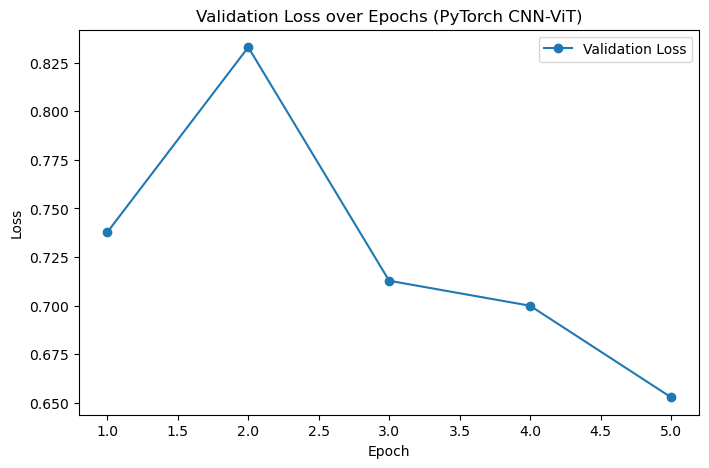

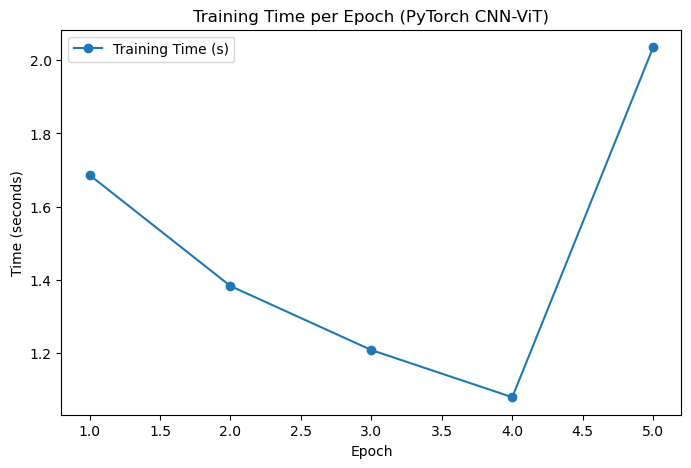

In [3]:
# =============================================
# QUESTION 8 — VISION TRANSFORMERS IN PYTORCH
# =============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time

# ------------------------------------------------------------
# DEVICE CONFIGURATION
# ------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("✅ Using device:", device)

# ------------------------------------------------------------
# TASK 1: Define train_transform
# ------------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# ------------------------------------------------------------
# TASK 2: Define val_transform
# ------------------------------------------------------------
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# ------------------------------------------------------------
# TASK 3: Create train_loader and val_loader
# ------------------------------------------------------------
dataset_path = '../images_dataSAT'   # adjust path if notebook is in notebooks/

train_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=dataset_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"✅ Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# ------------------------------------------------------------
# TASK 4: Define the CNN–ViT Hybrid model
# ------------------------------------------------------------
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=768, num_heads=12, depth=12):
        super(CNN_ViT_Hybrid, self).__init__()

        # CNN feature extractor (ResNet18 backbone)
        self.cnn = models.resnet18(weights=None)
        self.cnn.fc = nn.Identity()  # remove classification layer

        # Linear projection 512 -> 768 to match transformer embed_dim
        self.project = nn.Linear(512, embed_dim)

        # Vision Transformer Encoder (12 heads, 12 layers)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=1024, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Final classification head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Extract CNN features
        feats = self.cnn(x)              # (batch, 512)
        feats = self.project(feats)      # (batch, 768)

        # Simulate patch tokens by repeating features
        feats = feats.unsqueeze(1).repeat(1, 4, 1)  # (batch, seq_len=4, embed_dim=768)

        # Transformer encoder
        out = self.transformer(feats)    # (batch, seq_len, embed_dim)
        out = out.mean(dim=1)            # global average pooling

        # Classify
        out = self.classifier(out)
        return out

# ------------------------------------------------------------
# INITIALIZE MODEL, LOSS, OPTIMIZER
# ------------------------------------------------------------
model = CNN_ViT_Hybrid(
    num_classes=2,
    embed_dim=768,
    num_heads=12,
    depth=12
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ------------------------------------------------------------
# TRAINING CONFIGURATION
# ------------------------------------------------------------
epochs = 5
train_losses = []
val_losses = []
train_times = []

print("🚀 Training started...")

for epoch in range(epochs):
    start_time = time.time()

    # Training Phase
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Record training time
    epoch_time = time.time() - start_time
    train_times.append(epoch_time)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_time:.2f}s")

print("✅ Training complete.")

# ------------------------------------------------------------
# TASK 5: Plot Validation Loss Comparison
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), val_losses, marker='o', label='Validation Loss')
plt.title('Validation Loss over Epochs (PyTorch CNN-ViT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ------------------------------------------------------------
# TASK 6: Plot Training Time Comparison
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_times, marker='o', label='Training Time (s)')
plt.title('Training Time per Epoch (PyTorch CNN-ViT)')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()
